<font color = blue><font size = 6> 실험설명 </font></font><br>
이미 이전에 1step에서 RNN기반이 1step의 예측에 대해서 좋지 않다는 것을 몸소 경험했다 하지만 Online-learning에서는 좀 다른 결과가 나올까 기대감에 진행해 보았다<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('../data/5.csv')
data

,values
0,92408
1,92150
2,94896
3,92694
4,93674
...,...
38875,81521
38876,83092
38877,84873
38878,81736


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':8,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Model_Implementation/online_learning_seq2seq']

In [6]:
class Encoder(nn.Module):
    def __init__(self,configs):
        super(Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [7]:
class Decoder(nn.Module):
    def __init__(self,configs):
        super(Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        output = self.linear(lstm_out)
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [8]:
tup= (1,2)
len(tup)

2

In [9]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.encoder = Encoder(configs)
        self.decoder = Decoder(configs)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        _,final_hidden = self.encoder(x)
        output,_ = self.decoder(x = x[:,-1,:].view(-1,1,1),encoder_hidden = final_hidden)
        
        return output

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [11]:
sequence_length = 1440
pred_len = 1
split= 1440
x_data = pd.DataFrame({'values':data[:-split].reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_362048/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [12]:
x_seq

tensor([[[0.1487, 0.1481, 0.1538,  ..., 0.1609, 0.1565, 0.1615]],

        [[0.1481, 0.1538, 0.1493,  ..., 0.1565, 0.1615, 0.1608]],

        [[0.1538, 0.1493, 0.1513,  ..., 0.1615, 0.1608, 0.1595]],

        ...,

        [[0.1611, 0.1663, 0.1589,  ..., 0.1075, 0.1085, 0.1086]],

        [[0.1663, 0.1589, 0.1529,  ..., 0.1085, 0.1086, 0.1072]],

        [[0.1589, 0.1529, 0.1531,  ..., 0.1086, 0.1072, 0.1044]]],
       device='cuda:0')

In [14]:
device = torch.device('cuda:0')
batch_size = 128
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
device = torch.device("cuda:0")

In [16]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
        
        out = model(seq).to(device) #model parameter device랑 안맞는다고 하면 위의 셀에서 model을 gpu로 보내버리면 됨
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        

    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 78.56237336676172 %
smape 72.78594217983121 %
smape 68.38150602758776 %
smape 64.96624358209735 %
smape 61.22245029249089 %
smape 54.30750371921306 %
smape 47.40091444072413 %
smape 43.56551573558955 %
smape 40.36823086182964 %
smape 37.56514367092639 %
smape 35.926309159580384 %
smape 35.18723852417253 %
smape 34.76019458521606 %
smape 34.46594819439747 %
smape 34.24245458928512 %
smape 34.066249936132145 %
smape 33.91802827233171 %
smape 33.79219841898967 %
smape 33.68215844999497 %
smape 33.58738771573713 %
smape 33.50445268814393 %
smape 33.42780709689391 %
smape 33.35697354669583 %
smape 33.29521525908816 %
smape 33.23901146617288 %
smape 33.186539161474784 %
smape 33.13833616297454 %
smape 33.092935310333225 %
smape 33.05068923530321 %
smape 33.01137685742731 %
smape 32.97321541657579 %
smape 32.9383167567009 %
smape 32.906099616596144 %
smape 32.87546929559862 %
smape 32.84528244299986 %
smape 32.81678143419748 %
smape 32.78936006075947 %
smape 32.76347371399508 %
smape 32

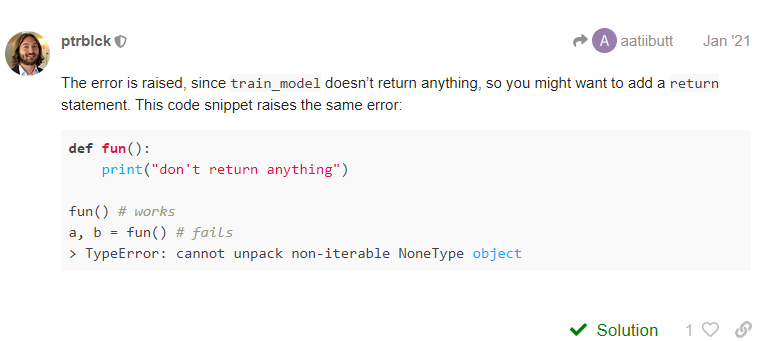
&uparrow; 위의 문제때문에 계속 TypeError: cannot unpack non-iterable NoneType object 에러가 났음
https://discuss.pytorch.org/t/typeerror-cannot-unpack-non-iterable-nonetype-object/108008/3

In [18]:
device = torch.device('cuda:0')
X =  pd.DataFrame({'values':data[:-split].reshape(-1)})
target = pd.DataFrame({'values':data[-split:].reshape(-1)})
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    for epochs in range(num_epochs):
        if idx == 0:
             new_train = torch.FloatTensor(
            [X.iloc[-sequence_length:].values]
        ).view(1,sequence_length,1).to(device)
                
        else:
            new_train = torch.FloatTensor(
                [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,sequence_length,1).to(device)

        out = model(new_train).to(device) # 예측완료
        
        tg = FloatTensor(target.iloc[idx]).view(1,1,1).to(device)
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(out.cpu().view(1).item())
    time_list.append(end-start)

SMAPE 2.470848224650581 %
SMAPE 0.5540125822599293 %
SMAPE 0.28592666478107276 %
SMAPE 0.15660656211184687 %
SMAPE 0.6759174843537039 %
SMAPE 0.5546438078308711 %
SMAPE 0.20729997435046243 %
SMAPE 0.8383234566535976 %
SMAPE 0.29492895193743607 %
SMAPE 0.4235242892345923 %
SMAPE 0.5350067823528661 %
SMAPE 0.48518122595123714 %
SMAPE 0.3861943303963926 %
SMAPE 0.3382468347354006 %
SMAPE 0.4571443555687438 %
SMAPE 0.556650890443052 %
SMAPE 0.46564005455547886 %
SMAPE 0.3078888055852076 %
SMAPE 0.4714175560729927 %
SMAPE 0.48798091590651893 %
SMAPE 0.42391109490563395 %
SMAPE 1.0051232288715255 %
SMAPE 1.418318081581674 %
SMAPE 0.944810345517908 %
SMAPE 0.48488117685701576 %
SMAPE 0.24058898739986034 %
SMAPE 0.8036962715195841 %
SMAPE 0.11350971351930639 %
SMAPE 0.4838932199263581 %
SMAPE 0.3999113559893885 %
SMAPE 0.8417036047321744 %
SMAPE 0.5009638108094805 %
SMAPE 0.39927351762889884 %
SMAPE 0.699074439558899 %
SMAPE 0.6156870114209596 %
SMAPE 1.1216917211349937 %
SMAPE 1.0614241642501

SMAPE 199.99995231628418 %
SMAPE 199.99994039535522 %
SMAPE 199.99995231628418 %
SMAPE 199.99995231628418 %
SMAPE 199.99995231628418 %
SMAPE 199.99995231628418 %
SMAPE 199.99995231628418 %
SMAPE 15.389321927952551 %
SMAPE 0.9675505114355474 %
SMAPE 1.4952132005983003 %
SMAPE 0.42341274422506103 %
SMAPE 0.9464611718212836 %
SMAPE 1.2232501296130067 %
SMAPE 0.6508173738893674 %
SMAPE 1.766817600497234 %
SMAPE 0.802106883356828 %
SMAPE 0.4328116667402355 %
SMAPE 0.395800615182452 %
SMAPE 0.6595478665549308 %
SMAPE 0.24705523122975137 %
SMAPE 0.37864203018853004 %
SMAPE 0.3300547084236314 %
SMAPE 0.37424436452238297 %
SMAPE 0.4100281272840221 %
SMAPE 2.270486259332756 %
SMAPE 0.8942404295557935 %
SMAPE 0.242594989831332 %
SMAPE 0.23206065867452708 %
SMAPE 0.1557607041004303 %
SMAPE 0.14855946654165564 %
SMAPE 0.4817386131417151 %
SMAPE 0.35916261869715527 %
SMAPE 0.19216409754153574 %
SMAPE 0.22958293980809685 %
SMAPE 1.4676408862142125 %
SMAPE 0.1728886139462702 %
SMAPE 0.3675290956889512

SMAPE 0.08920941020301143 %
SMAPE 0.4194217040069361 %
SMAPE 0.1194256364158832 %
SMAPE 0.021405785764386565 %
SMAPE 0.09822398572396196 %
SMAPE 0.3316826435271025 %
SMAPE 0.07919309933276963 %
SMAPE 0.16947970675198576 %
SMAPE 0.24609316177475193 %
SMAPE 0.3621742271786843 %
SMAPE 0.12568034816285945 %
SMAPE 0.051615966872304846 %
SMAPE 0.20529358153044086 %
SMAPE 0.34516950438853655 %
SMAPE 0.10376882228592876 %
SMAPE 0.209156434755414 %
SMAPE 0.32389026110831765 %
SMAPE 0.08964610949237795 %
SMAPE 0.0753194459794031 %
SMAPE 0.22686378897014947 %
SMAPE 0.31041623264081863 %
SMAPE 0.06734877044800669 %
SMAPE 0.09807285245187815 %
SMAPE 0.027793090018803927 %
SMAPE 0.12113332446460844 %
SMAPE 0.32042368811698907 %
SMAPE 0.16011252078044436 %
SMAPE 0.2592406550038504 %
SMAPE 0.12032755816744611 %
SMAPE 0.025774689428544665 %
SMAPE 0.08742737694183234 %
SMAPE 0.248810292936696 %
SMAPE 0.17509071859171854 %
SMAPE 0.09570231455336398 %
SMAPE 0.1490000090570902 %
SMAPE 0.03926568248937201 %

SMAPE 0.09109878355320689 %
SMAPE 0.4116371020718362 %
SMAPE 0.09275292204938523 %
SMAPE 0.13893390905104752 %
SMAPE 0.026048815938565895 %
SMAPE 0.028345657959107484 %
SMAPE 0.0578674470691567 %
SMAPE 0.20356079363045865 %
SMAPE 0.16452244762695045 %
SMAPE 0.047876677641625065 %
SMAPE 0.07632419410447255 %
SMAPE 0.17671741517818873 %
SMAPE 0.07220196037997084 %
SMAPE 0.2054269245636533 %
SMAPE 0.28656988098595093 %
SMAPE 0.09657780147654194 %
SMAPE 0.17137850947437983 %
SMAPE 0.2149966601797928 %
SMAPE 0.41098288376815617 %
SMAPE 0.03909981276729013 %
SMAPE 0.05422760703913809 %
SMAPE 0.17473779142892454 %
SMAPE 0.16319592306081177 %
SMAPE 0.14105982812350248 %
SMAPE 0.21672477609718044 %
SMAPE 0.02552016926858869 %
SMAPE 0.05134053516303538 %
SMAPE 0.025525567359181878 %
SMAPE 0.08147661298653475 %
SMAPE 0.05183652984351284 %
SMAPE 0.07621146576946103 %
SMAPE 0.11009021595930334 %
SMAPE 0.23514190924743159 %
SMAPE 0.23228047734846768 %
SMAPE 0.19516384651979024 %
SMAPE 0.178765461605

SMAPE 0.12093726411058014 %
SMAPE 0.06779442410606862 %
SMAPE 0.18236237544169853 %
SMAPE 0.28880513279545994 %
SMAPE 0.10112072287347473 %
SMAPE 0.024450761617117678 %
SMAPE 0.0987601225006074 %
SMAPE 0.032760900301582296 %
SMAPE 0.1934951531511615 %
SMAPE 0.46635468828662857 %
SMAPE 0.37835414644359844 %
SMAPE 0.4189302118356863 %
SMAPE 0.07053150781945305 %
SMAPE 0.2639156397963234 %
SMAPE 0.02691856116564395 %
SMAPE 0.6042721479107058 %
SMAPE 0.1482792602164409 %
SMAPE 0.09067017997222138 %
SMAPE 0.28188685425448057 %
SMAPE 0.09729533965933967 %
SMAPE 0.08432536081377151 %
SMAPE 0.08997965756134363 %
SMAPE 0.058966552544006845 %
SMAPE 0.04092911385487241 %
SMAPE 0.033375030481238355 %
SMAPE 0.16901691855719037 %
SMAPE 0.26746817306138837 %
SMAPE 0.13036877820887582 %
SMAPE 0.03337566374011658 %
SMAPE 0.42820952640869336 %
SMAPE 0.1125841989996843 %
SMAPE 0.20999366328851463 %
SMAPE 0.2648459115616788 %
SMAPE 0.4259172893546293 %
SMAPE 0.4122351946282379 %
SMAPE 0.2550609721181445 %

In [23]:
len(pred_list)

1440

In [25]:
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 15.38732624053955 %


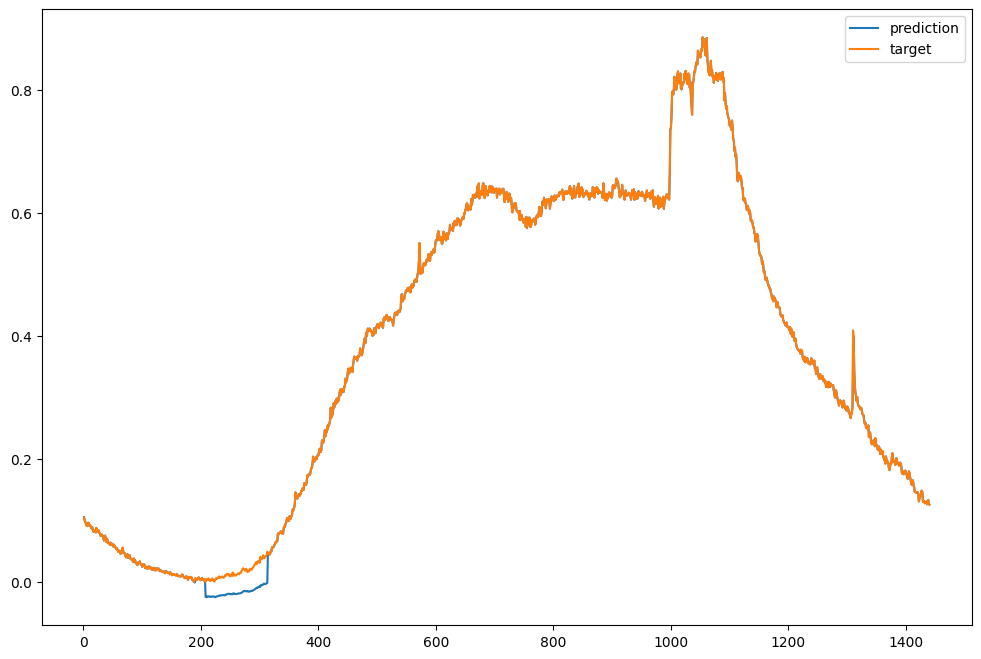

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,1441),pred_list,label='prediction')
axes.plot(np.arange(1,1441),target,label='target')
axes.legend()

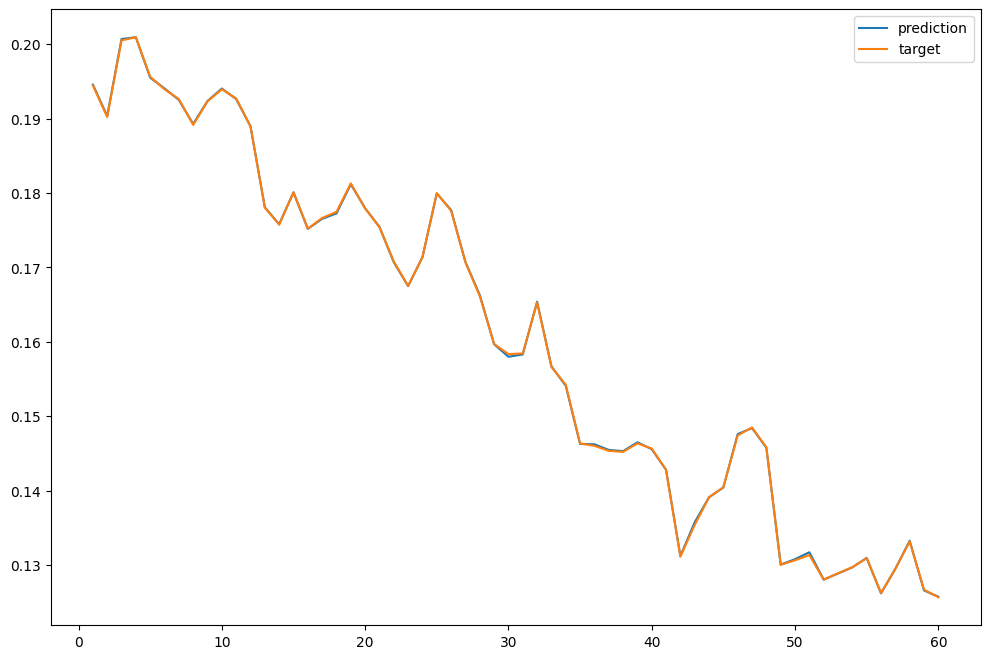

In [27]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [28]:
np.mean(time_list)

0.646279538836744

<font color = blue><font size = 6> Conclusion </font></font><br>
DLienar online-learning과 NLinear online-learning에 비하면 매우 안좋은 SMAPE값이다 또한 한번 훈련하는데 0.6초가 걸렸는데 이는 속도가 무려 3배나 느리다는 것을 알려준다